In [3]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import pandas as pd
import seaborn as sns
from multiprocessing import Pool
import corner
from scipy.optimize import minimize
from scipy import interpolate
from IPython.display import display, Markdown
sns.set_context('talk')

In [2]:
from astropy.cosmology import FlatLambdaCDM

# (0) Data prep
This section is data dependent

## (0-0) load data & prep values

In [11]:
df = pd.read_csv('data/pantheon_mass_SFR_partial.csv').set_index('CID')
df.head()

,CIDint,IDSURVEY,TYPE,FIELD,CUTFLAG_SNANA,zCMB,zCMBERR,zHD,zHDERR,VPEC,...,logssfr,z_bin,sigma_muz,mB_unbiased,x1_unbiased,c_unbiased,R_V,A_V,COV_x1_mB,COV_c_mB
CID,,,,,,,,,,,,,,,,,,,,,
03D1au,1.0,4.0,0.0,D1,1.0,0.50349,0.0,0.50309,0.0,-120.8530,...,-10.508,0.475735,0.0,22.7513,1.148000,-0.017537,3.145428,0.565609,-0.000850,-0.000445
03D1aw,121.0,4.0,0.0,D1,1.0,0.58119,0.0,0.58073,0.0,-139.2610,...,-9.855,0.599943,0.0,23.3225,0.934600,-0.032488,3.071607,0.607843,-0.002976,-0.000411
03D1ax,2.0,4.0,0.0,D1,1.0,0.49520,0.0,0.49480,0.0,-118.3600,...,-12.069,0.475735,0.0,22.7207,-0.675943,-0.070688,3.052820,0.599902,-0.000579,-0.000438
03D1bp,122.0,4.0,0.0,D1,1.0,0.34621,0.0,0.34593,0.0,-81.5618,...,-10.514,0.333460,0.0,22.1485,-1.120730,-0.039099,2.584896,0.871990,-0.001120,-0.000631
03D1co,3.0,4.0,0.0,D1,1.0,0.67820,0.0,0.67767,0.0,-160.6590,...,-10.312,0.672927,0.0,23.8310,0.679000,-0.043794,3.400834,0.445970,-0.012204,-0.000846


In [19]:
print(df.columns.values)

['CIDint' 'IDSURVEY' 'TYPE' 'FIELD' 'CUTFLAG_SNANA' 'zCMB' 'zCMBERR' 'zHD'
 'zHDERR' 'VPEC' 'VPEC_ERR' 'HOST_LOGMASS' 'HOST_LOGMASS_ERR' 'SNRMAX1'
 'SNRMAX2' 'SNRMAX3' 'PKMJD' 'PKMJDERR' 'x1' 'x1ERR' 'c' 'cERR' 'mB'
 'mBERR' 'x0' 'x0ERR' 'COV_x1_c' 'COV_x1_x0' 'COV_c_x0' 'NDOF' 'FITCHI2'
 'FITPROB' 'RA' 'DECL' 'TGAPMAX' 'TrestMIN' 'TrestMAX' 'MWEBV' 'MU'
 'MUMODEL' 'MUERR' 'MUERR_RAW' 'MURES' 'MUPULL' 'ERRCODE' 'biasCor_mu'
 'biasCorErr_mu' 'biasCor_mB' 'biasCor_x1' 'biasCor_c' 'biasScale_muCOV'
 'IDSAMPLE' 'logmass' 'logssfr' 'z_bin' 'sigma_muz' 'mB_unbiased'
 'x1_unbiased' 'c_unbiased' 'R_V' 'A_V' 'COV_x1_mB' 'COV_c_mB']


Note: below are list of important quantities

|name|description|
|----|-----------|
|zHD | peculiar velocity-corrected redshift. use this.|
|x1, x1ERR| stretch parameter from SALT2 |
|c,  cERR| color parameter from SALT2 |
|x0, x0ERR| maximum B-band flux. Can be converted to mB|
|mB, mBERR| max B-band mag calculated from x0|
|biasCor_x1| calculated bias in x1 (subtract this from x1) |
|biasCor_c| calculated bias in c (subtract this from c) |
|biasCor_mB| calculated bias in mB (subtract this from mB) |
|COV_x1_c | covariance btw. x1 and c|
|COV_x1_x0| covariance btw. x1 anx x0. <br>Can be converted to Cov_x1_mB. 
|COV_c_x0| covariance btw. c and c0. <br> Canbe converted to Cov_c_mB.
|biasScale_muCOV| scale factor for correcting overestimated uncertainty
|logmass| log stellar mass of host galaxy (use this)|

In [22]:
# run the followings:

# pec-velocity uncertainty
df['sigma_muz'] = (5/np.log(10))*\
                    (1+df['zHD'])/\
                    (df['zHD']*(1+df['zHD']/2))*\
                    np.sqrt(df['zHDERR']**2+(df['VPEC_ERR']/3e5)**2)

# bias-corrected values
df['mB_unbiased'] = df['mB']-df['biasCor_mB']
df['x1_unbiased'] = df['x1']-df['biasCor_x1']
df['c_unbiased'] = df['c']-df['biasCor_c']

# covariance converted for mB (from x0: see eqn. below)
df['COV_x1_mB'] = (2.5/np.log(10)/df['x0']) * df['COV_x1_x0']
df['COV_c_mB'] = (2.5/np.log(10)/df['x0']) * df['COV_c_x0']

$$ \sigma_{m_B} = \frac{2.5}{\ln(10) x_0}\sigma_{x_0} \Rightarrow \frac{\partial \sigma_{m_B}}{\partial \sigma_{x_0}} =  \frac{2.5}{\ln(10) x_0}$$

$$\Sigma_{m_B,c} = \frac{\partial \sigma_{m_B}}{\partial \sigma_{x_0}}\Sigma_{x0,c} = \frac{2.5}{\ln(10) x_0}\Sigma_{x0,c}$$

## (0-1) find binning with (almost) uniform mu-spacing

Perform a binning by redshift values. Bin sizes are determined so that the resulting binning size in $\mu$-space is uniform (= uniform binning with an inverse function of distmod)

In [25]:
##### config #####
zmin = 0.01
zmax = 1.0
delta_mu = 0.2
##################

# theoretical distmod
cosmo = FlatLambdaCDM(H0=74,Om0=0.3)
z_th = np.linspace(0.001,2.0,10000)
mu_th = cosmo.distmod(z_th)

# inverse function
distmod_inv = interpolate.interp1d(mu_th, z_th)

# distmod binning
mu_min = cosmo.distmod(zmin).value
mu_max = cosmo.distmod(zmax).value
mu_Nbin = int((mu_max-mu_min)/delta_mu)
mu_uniform = np.linspace(mu_min,mu_max,mu_Nbin+1)
z_edges = distmod_inv(mu_uniform)
z_centers = (z_edges[1:]+z_edges[:-1])/2

# results
print('bin size:',len(z_centers))
print(f'mean delta_mu in each bin: {np.mean(mu_uniform[1:]-mu_uniform[:-1]):.3f}')

bin size: 54
mean delta_mu in each bin: 0.202


Text(0, 0.5, 'counts')

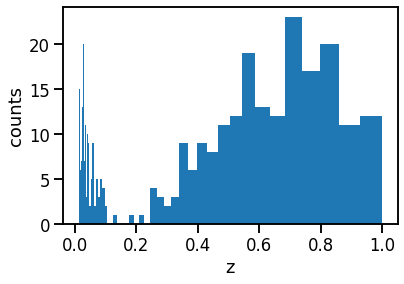

In [26]:
# apply binning
df['z_bin'] = pd.cut(df['zHD'],bins=z_edges,labels=z_centers)
plt.hist(df['zHD'],bins=z_edges)
plt.xlabel('z');plt.ylabel('counts')

### also... let's take a look at the mass distribution

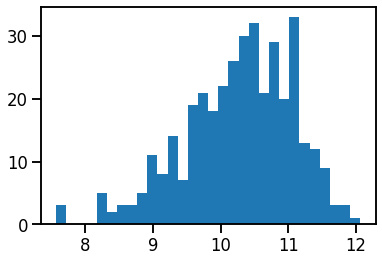

In [59]:
plt.hist(df['logmass'],bins=30);

# (1) MCMC for nuisance parameters

## (1-0) visualize mass-step model

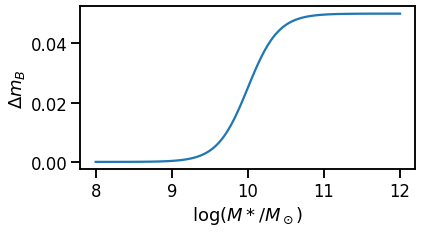

In [57]:
# mass-step model from Pantheon paper
# parameters
gamma = 0.05 # size
mstep_loc=10 # location
tau = 0.2    # width of transition

mass_th = np.linspace(8,12,100)
mstep_th = gamma/(1+np.exp(-(mass_th-mstep_loc)/tau))
plt.figure(figsize=(6,3))
plt.plot(mass_th,mstep_th)
plt.ylabel(r'$\Delta m_B$')
plt.xlabel(r'$\log(M*/M_\odot)$');

## (1-1) functions to calculate HR

In [27]:
def weighted_avg(values,err):
    weights = 1/np.asarray(err)**2
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [28]:
def get_HR_zbin(alpha,beta,gamma,mstep_loc,tau,sigma_int,df):
    # mass-step
    mstep = gamma/(1+np.exp(-(df['logmass']-mstep_loc)/tau))
    
    # distmod
    mu_obs = df['mB_unbiased'] + alpha*df['x1_unbiased'] - beta*df['c_unbiased'] + mstep
    
    # photometric uncertainty 
    sigma_N2 = df['mBERR']**2 \
                + alpha**2*df['x1ERR']**2 \
                + beta**2*df['cERR']**2 \
                - 2*alpha*beta*df['COV_x1_c'] \
                + 2*alpha*df['COV_x1_mB'] \
                - 2*beta*df['COV_c_mB']
    
    # uncertainty due to lensing
    sigma_lens = 0.055*df['zHD']
    
    # mass-step uncertainty
    ## TODO
    ## add mass-step uncertainty here and below
    
    # total uncertainty
    # (notice sigma_muz needs to be independent from biasScale)
    mu_err = np.sqrt(
        df['biasScale_muCOV']*(sigma_N2 + sigma_lens**2 + sigma_int**2)\
        + df['sigma_muz']**2
    )   
        
    # calculate HR (= deviation from binned mean)
    HR = 0*np.ones_like(mu_obs) 
    for z_bin in df['z_bin'].unique():
        bin_data = df['z_bin']==z_bin
        
        # HR=0 if there is only one sample in a bin
        if bin_data.sum() == 1:
            _mu = mu_obs[bin_data] 
            _mu_err = mu_err[bin_data]
            HR[bin_data] = 0
            
        # calculate HR otherwise
        elif bin_data.sum() > 1:
            _mu = mu_obs[bin_data] 
            _mu_err = mu_err[bin_data]
            avg,_ = weighted_avg(_mu,_mu_err)
            HR[bin_data] = _mu-avg
            
    return HR,mu_err

rms 0.13119619241511954


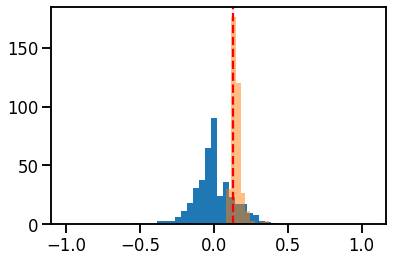

In [56]:
# test HR code
# params : [alpha,beta,gamma,mstep_loc,tau,sigma_int]
params=[0.15,3.5,0.05,10,0.1,0.1]
HR,mu_err = get_HR_zbin(*params,df)
rms = np.sqrt(np.mean(HR**2))

plt.hist(HR,bins=np.linspace(-1,1,50));
plt.hist(mu_err,bins=30,alpha=0.5);
plt.axvline(rms,alpha=1,ls='--',color='red');
print('rms',rms)

## (1-2) MCMC prep (likelihood functions)

In [41]:
def log_likelihood(theta,df):
    '''
    Returns the log-likelihood of the model
    Calculate the weighted average in each redshift bin to perform fitting
    '''
    alpha,beta,gamma,mstep_loc,tau,sigma_int = theta
    
    HR,HR_err = get_HR_zbin(alpha,beta,gamma,mstep_loc,tau,sigma_int,df)

    chi2  = HR**2/(HR_err**2)
    return -0.5*np.sum(chi2) - 0.5*np.log(2*np.pi*(HR_err**2)).sum()

In [38]:
def log_prior(theta,priors):
    '''
    log-prior for the parameters
    '''

    ## Uniform prior
    ## SN people seem to prefer uniform prior
    mu,halfwidth = priors
    
    for i in range(len(theta)):
        if theta[i]>mu[i]+halfwidth[i] or theta[i]<mu[i]-halfwidth[i]:
            return -np.inf
    return 1
    
    
    ## Gaussian prior
#     mu,sigma = priors
#     logprior = 0

#     if theta[-1]<0: # sigma_int cannot be negative
#         return -np.inf
        
#     for i in range(len(theta)):
#         chi2 = (mu[i]-theta[i])**2/(sigma[i]**2)
#         logprior += -0.5*chi2 - 0.5*np.log(2*np.pi*(sigma[i]**2))
#     return logprior

In [39]:
def log_probability(theta,df,priors):
    '''
    log-probability in total
    '''
    lp = log_prior(theta,priors)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta,df)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [42]:
# test
log_likelihood([0.15,0.5,0.05,10,0.1,0.1],df)

-321.9970960462955

## (1-3) run MCMC

In [60]:
# MCMC settings
nwalkers = 20 # number of walkers
chain = 1000  # number of samples: making this large makes the distribution clean
burnin = 300  # this should be large enough to discard any chain before convergence

# priors [alpha,beta,gamma,mstep_loc,tau,sigma_int]
mu_list = np.array([0.2,3,0.1,10,0.15,0.1]) # center values
width_list = np.array([0.2,2,0.1,1.5,0.15,0.1]) # half width of uniform prior
priors = [mu_list,width_list]

# initial guess array for each walker: 
x0 = mu_list
# x0 = np.array(x0) + np.random.normal(loc=0,scale=sigma_list,size=(nwalkers,len(x0)))
x0 = np.random.uniform(mu_list-width_list,mu_list+width_list,size=(nwalkers,len(x0)))
nwalkers, ndim = x0.shape

# initialize sampler, run MCMC
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=[df,priors],pool=pool)
    sampler.run_mcmc(x0, chain, progress=True,skip_initial_state_check=True);

  4%|▍         | 43/1000 [00:11<03:19,  4.80it/s]/home/sterlingym/anaconda3/envs/base2/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
  6%|▌         | 55/1000 [00:13<03:27,  4.55it/s]/home/sterlingym/anaconda3/envs/base2/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
 27%|██▋       | 267/1000 [01:02<02:42,  4.50it/s]/home/sterlingym/anaconda3/envs/base2/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
 29%|██▉       | 288/1000 [01:07<02:36,  4.54it/s]/home/sterlingym/anaconda3/envs/base2/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
 30%|███       | 302/1000 [01:

## (1-4) results

**!! NOTE: tau did not converge. This is just a demonstration !!**

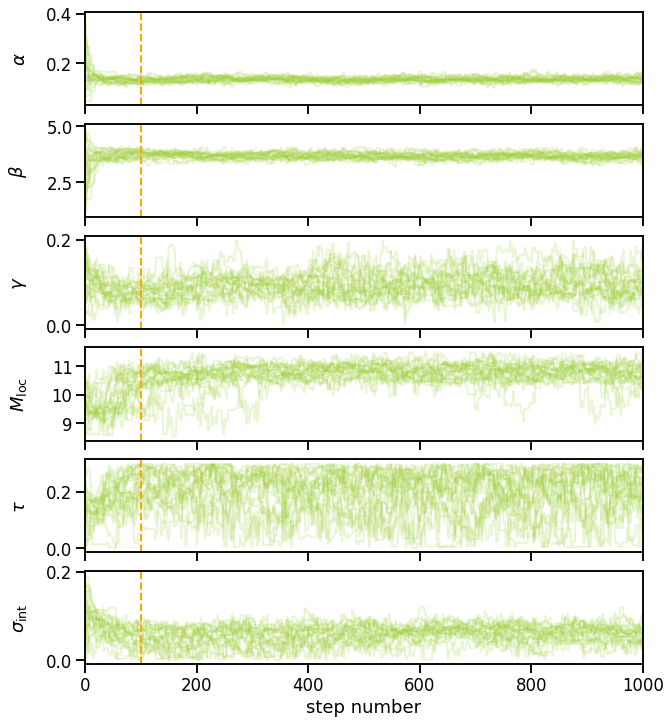

In [61]:
burnin=100
fig, axes = plt.subplots(ndim, figsize=(10, 2*ndim), sharex=True)
samples = sampler.get_chain()
labels = [r"$\alpha$", r"$\beta$", r"$\gamma$", 
          r"$M_\mathrm{loc}$",r"$\tau$",r"$\sigma_\mathrm{int}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "yellowgreen", alpha=0.2, lw=2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axvline(burnin,ls='--',color='orange',lw=2)
axes[-1].set_xlabel("step number");

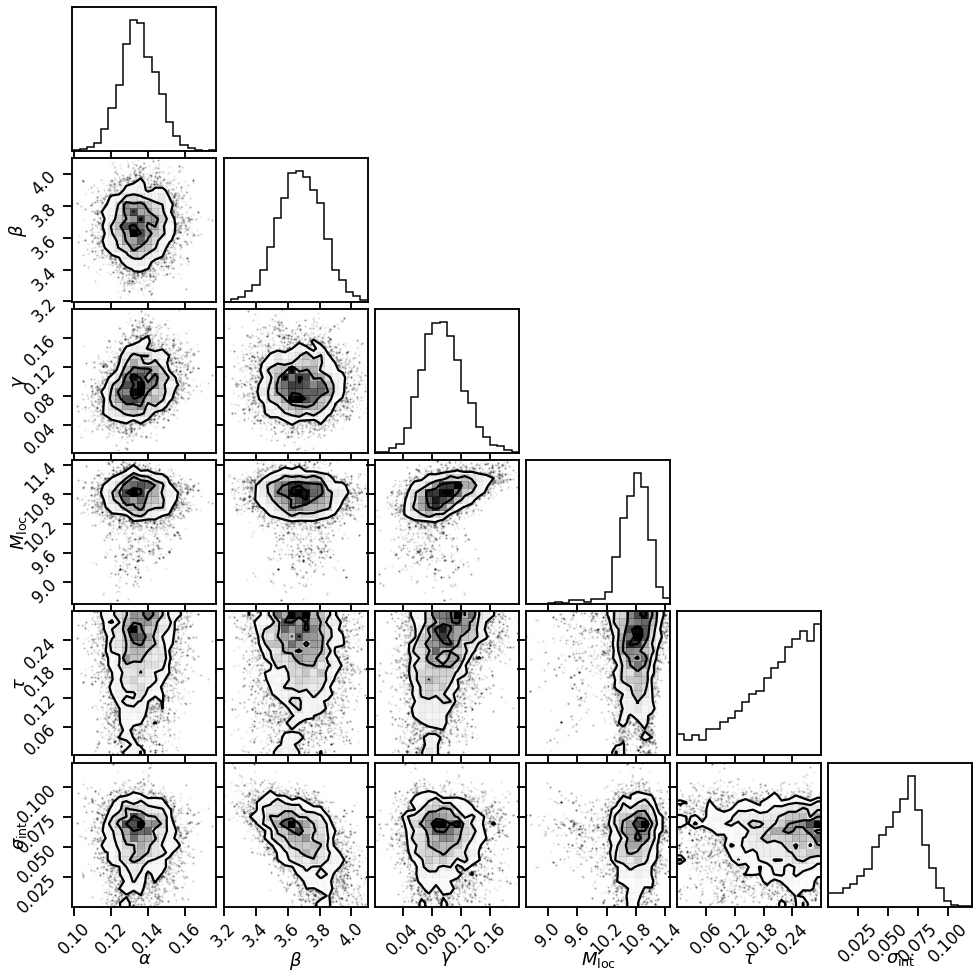

In [62]:
flat_samples = sampler.get_chain(discard=burnin, flat=True)
fig = corner.corner(flat_samples, labels=labels);

$\alpha$:  $ 0.135^{+0.005}_{-0.004}$

$\beta$:  $ 3.676^{+0.069}_{-0.065}$

$\gamma$:  $ 0.094^{+0.013}_{-0.013}$

$M_\mathrm{loc}$:  $ 10.793^{+0.125}_{-0.143}$

$\tau$:  $ 0.218^{+0.032}_{-0.041}$

$\sigma_\mathrm{int}$:  $ 0.061^{+0.008}_{-0.011}$

rms(HR): 0.1285
chi2/dof: 361.1/404


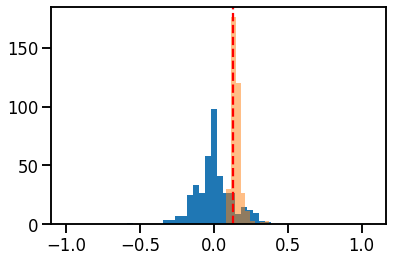

In [64]:
mpv_list = []
width_list = []
for i in range(ndim):
    mpv = np.percentile(flat_samples[:,i],50)
    upper = np.percentile(flat_samples[:,i],68)-mpv
    lower = mpv - np.percentile(flat_samples[:,i],32)
    text = labels[i]+r":  $ mpv^{+upper}_{-lower}$"
    text = text.replace('mpv',f'{mpv:.3f}').replace('upper',f'{upper:.3f}').replace('lower',f'{lower:.3f}')
    display(Markdown(text))
    mpv_list.append(mpv)
    width_list.append(abs(upper-lower)/2)
# best-fit results
HR,HR_err = get_HR_zbin(*mpv_list,df)
rms = np.sqrt(np.mean(HR**2))
print(f'rms(HR): {rms:.4f}')
print(f'chi2/dof: {(HR**2/HR_err**2).sum():.1f}/{(len(HR)-len(mpv_list))}')

plt.hist(HR,bins=np.linspace(-1,1,50));
plt.hist(mu_err,bins=30,alpha=0.5);
plt.axvline(rms,alpha=1,ls='--',color='red');

(7.5, 12.2)

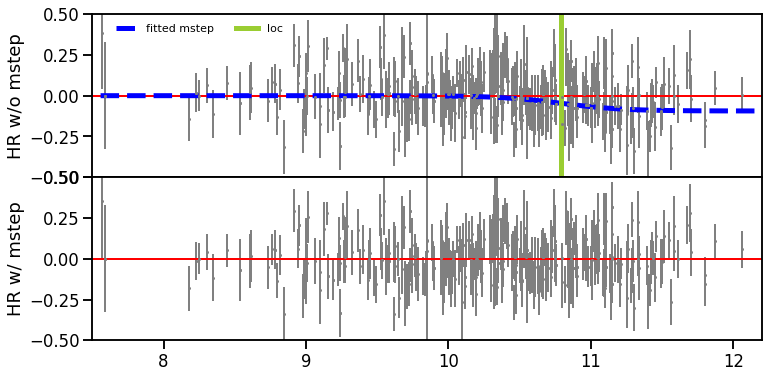

In [106]:
alpha = mpv_list[0]
beta = mpv_list[1]
gamma = mpv_list[2] # size
mstep_loc=mpv_list[3] # location
tau = mpv_list[4]    # width of transition
sigma_int = mpv_list[5]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6),sharex=True)
plt.subplots_adjust(hspace=0)

# before mass-step correction
HR,HR_err = get_HR_zbin(alpha,beta,0,mstep_loc,tau,sigma_int,df)
mass_th = np.linspace(7,12.5,100)
mstep_th = gamma/(1+np.exp(-(mass_th-mstep_loc)/tau))
ax1.errorbar(df['logmass'],HR,yerr=HR_err,ms=2,lw=2,color='grey',fmt='o')
ax1.axhline(0,color='red',lw=2)
ax1.plot(mass_th,-mstep_th,color='blue',lw=5,ls='--',label='fitted mstep')
ax1.axvline(mstep_loc,color='yellowgreen',lw=5,label='loc')
ax1.set_ylabel('HR w/o mstep')
ax1.set_ylim(-0.5,0.5)
ax1.legend(bbox_to_anchor=(0.02,1),loc='upper left',
           ncol=2,fontsize=11,frameon=False)
# after mass-step correction
HR,HR_err = get_HR_zbin(alpha,beta,gamma,mstep_loc,tau,sigma_int,df)
ax2.errorbar(df['logmass'],HR,yerr=HR_err,ms=2,lw=2,color='grey',fmt='o')
ax2.axhline(0,color='red',lw=2)
ax2.set_ylabel('HR w/ mstep')
ax2.set_ylim(-0.5,0.5)
ax2.set_xlim(7.5,12.2)
# plt.xlabel(r'$\log(M*/M_\odot)$');